In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, accuracy_score, balanced_accuracy_score
import os

In [2]:
### softmax

### dla wersji gdzie zapisujemy softmax
# dla wybranej osoby np. s03 bo ma ładne wyniki


subject = 's03'
pred_path = 'predictions/linear-sleepedf-AASM-pool1-temazepam-TRUE/linear-sleepedf-AASM-pool1-temazepam-TRUE' + '_' + subject + '.npy'
pred_softmax_path = 'predictions/linear-sleepedf-AASM-pool1-temazepam-TRUE/linear-sleepedf-AASM-pool1-temazepam-TRUE' + '_' + subject + '_softmax.npy'
signal_path = '/dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/temazepam_test/s03/ST7242J0-PSG.edf'

# AASM
labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']        
classes = [0, 1, 2, 3, 4]

in_and_out_labels = np.load(pred_path)
                     
y_true = in_and_out_labels[0]
y_BENDR = in_and_out_labels[1]
predictions_softmax = np.load(pred_softmax_path)


conf_matrix = confusion_matrix(y_true, y_BENDR, labels=classes, normalize='true') # true

MCC = matthews_corrcoef(y_true, y_BENDR)
ACC = accuracy_score(y_true, y_BENDR)
BAC = balanced_accuracy_score(y_true, y_BENDR)

print(accuracy_score(y_true, y_BENDR))
print(balanced_accuracy_score(y_true, y_BENDR))

0.774468085106383
0.7774723044116894


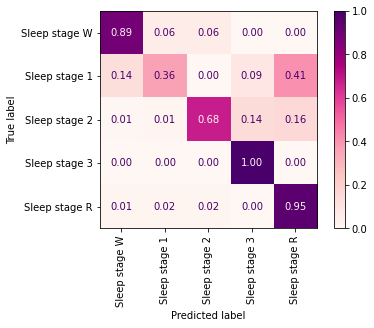

In [3]:
cmap = 'RdPu'
values_format = ".2f" 

ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels).plot(
    include_values=True, cmap=cmap, values_format=".2f")

plt.xticks(rotation=90)
plt.show()

In [4]:
# load examplatory signal

raw = mne.io.read_raw_edf(signal_path)

raw_filtered = raw.copy().load_data()
raw_filtered.filter(l_freq=1, h_freq=None)
# raw_filtered.filter(l_freq=10, h_freq=None)

Extracting EDF parameters from /dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/temazepam_test/s03/ST7242J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2947999  =      0.000 ... 29479.990 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)



<RawEDF | ST7242J0-PSG.edf, 5 x 2948000 (29480.0 s), ~112.5 MB, data loaded>

In [5]:
# znajdz najwyższą predykcję z błędnych predykcji s3
    # znajdz najwyższą błędną predykcję
    # powinno być stadium 1, a predykacja na s3

def explore_best_predictions(raw1, y_true, y_BENDR, predictions_softmax, true=1, predicted=1):

    indexes = [i for i in range(len(y_true)) if (y_true[i]==true) and (y_BENDR[i]==predicted)]
    preds = np.max(predictions_softmax[indexes], axis=1)
    preds_max = np.argmax(predictions_softmax[indexes, predicted])
    ind_max_pred = indexes[preds_max]

    print(f'Maksymalna predykcja: {predictions_softmax[ind_max_pred, predicted]} dla ind = {ind_max_pred} przy przewidywaniu ind = {true}')

    raw1.plot(duration=30, start=30*ind_max_pred, n_channels=len(raw.ch_names),scalings=1e-4)
    
    return ind_max_pred

Maksymalna predykcja: 0.9862396121025085 dla ind = 931 przy przewidywaniu ind = 2


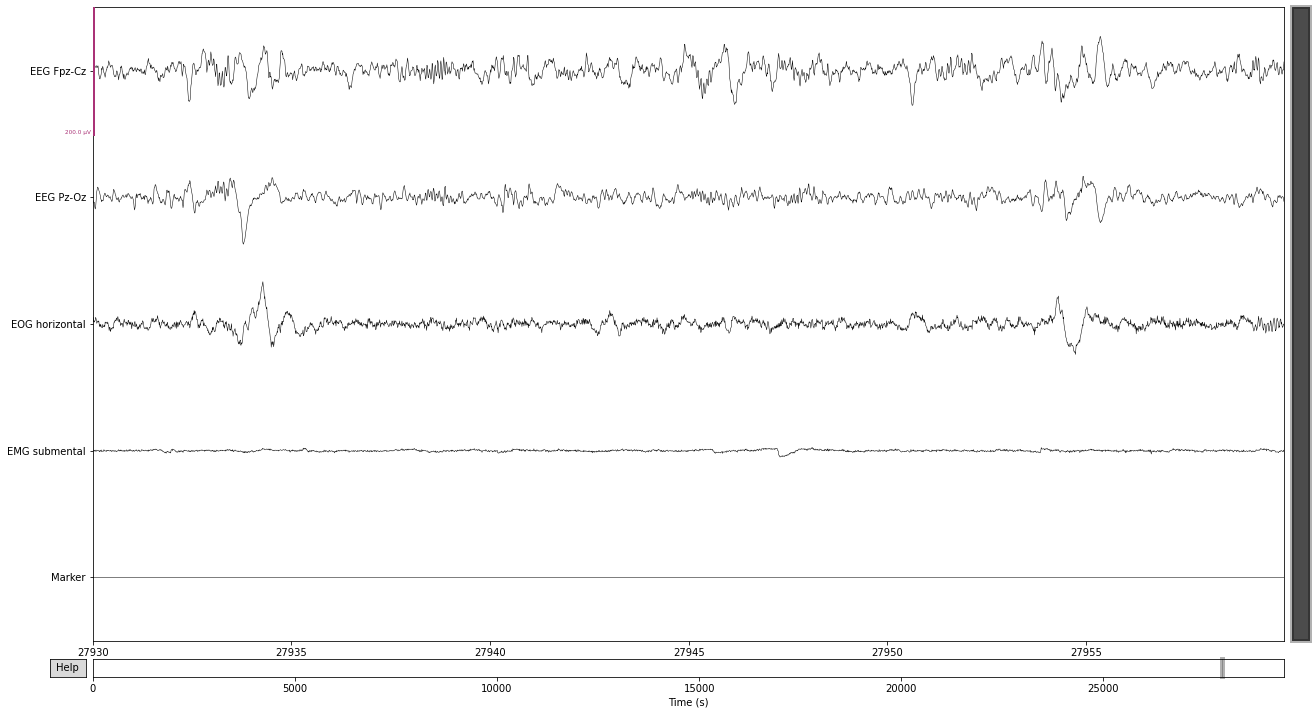

In [14]:
plt.rcParams["figure.figsize"] = [18,10]
max_ind = explore_best_predictions(raw_filtered, y_true, y_BENDR, predictions_softmax, true=2, predicted=2)

labels = ['REM', 'Stadium 3', 'Stadium 2', 'Stadium 1', 'Wake', 'Mięśnie']
classes = [0, 1, 2, 3, 4, 5]

In [7]:
# montaż

data = raw_filtered.get_data()
print(data.shape)

# 22, 21 to A1 i A2
A1 = data[21, :] * 10**6
A2 = data[22, :] * 10**6
print((A1+A2)/2)
print(data[0,:])
data -= (data[21, :] + data[22, :]) / 2

(5, 2948000)


IndexError: index 21 is out of bounds for axis 0 with size 5

In [ ]:
signal = raw_filtered.copy()

def f(arr, a1=A1, a2=A2):
    arr *= 10**6
    
    arr = arr - ((a1 + a2)/2)
    return arr / 10**6


picks = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']    

signal.apply_function(f, picks, channel_wise=True)


In [8]:
max_ind = explore_best_predictions(signal, y_true, y_BENDR, predictions_softmax, true=4, predicted=4)
print(max_ind)

NameError: name 'signal' is not defined

In [9]:
# widmo dla tego odcinka
# max_ind * f_samp, max_ind 

fs = 128
plt.figure(figsize=(20,5))
data = raw_filtered.get_data()

print(max_ind*20 + 20)
C4_cut = data[11, max_ind*20*fs : (max_ind*20 + 20)*fs]
plt.plot(C4_cut)

1480


IndexError: index 11 is out of bounds for axis 0 with size 5

<Figure size 1440x360 with 0 Axes>

In [10]:
import numpy.fft as fft

plt.figure(figsize=(20,5))


Syg = fft.fft(C4_cut)
f = fft.fftfreq(len(C4_cut), 1/128) #os czestosci
widmo_amp = np.abs(Syg)
#print(f)
plt.plot(f, widmo_amp) #od 0 do 100 to czestosci ktore odpowiadaja dodatnik f, a pozozstale odpowiadaja ujemnym
# plt.stem(f,widmo_amp) 
plt.xlim([0,64])
plt.xlabel('Frequency [Hz]')
plt.show()

NameError: name 'C4_cut' is not defined

<Figure size 1440x360 with 0 Axes>